In [2]:
import os
import random
import torch
import importlib
import src.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 


In [3]:
path=os.getcwd()
path

'/media/data/home/darcy/master_summary'

In [4]:
file=pd.read_csv(path+'/datasets/stock_preprocess.csv')
data=(file-file[:-2993].min())/(file[:-2993].max()-file[:-2993].min())
scale=[file[:-2993].max().tolist(),file[:-2993].min().tolist()]
data1=data.values
scale
#file[:-2993]

[[127.45,
  842.2999999999997,
  100.54,
  43.08,
  157.03,
  94.02,
  97.44,
  24.02,
  178.51],
 [121.55, 814.22, 94.78, 42.13, 152.39, 88.23, 93.65, 22.21, 168.29]]

In [4]:
file.shape

(8993, 9)

In [5]:
file=pd.read_csv(path+'/datasets/stock_preprocess.csv')[0:8000]
file[:-2000]

,CTAS,GOOG,HAS,HOLX,IDXX,JBHT,KLAC,LILAK,SHPG
0,124.20000,820.0000,98.85000,42.720,153.51,89.4200,95.57,22.480000,177.650
1,124.34790,820.6900,99.16230,42.620,153.44,90.7200,95.67,22.406667,178.080
2,124.58395,820.3010,98.93615,42.700,153.15,90.5100,95.77,22.333333,177.870
3,124.82000,819.0000,98.71000,42.600,152.60,90.5275,95.84,22.260000,177.865
4,124.64000,819.3400,98.71000,42.640,152.96,90.5450,95.86,22.220000,177.870
...,...,...,...,...,...,...,...,...,...
5995,122.89500,841.4600,95.54000,42.500,156.30,89.3000,96.51,22.475000,170.930
5996,122.89000,841.4316,95.53000,42.500,156.28,89.3500,96.53,22.470000,170.960
5997,122.90000,841.5900,95.57000,42.500,156.27,89.3300,96.54,22.470000,170.885
5998,122.91000,841.7300,95.59000,42.510,156.28,89.3400,96.46,22.480000,170.835


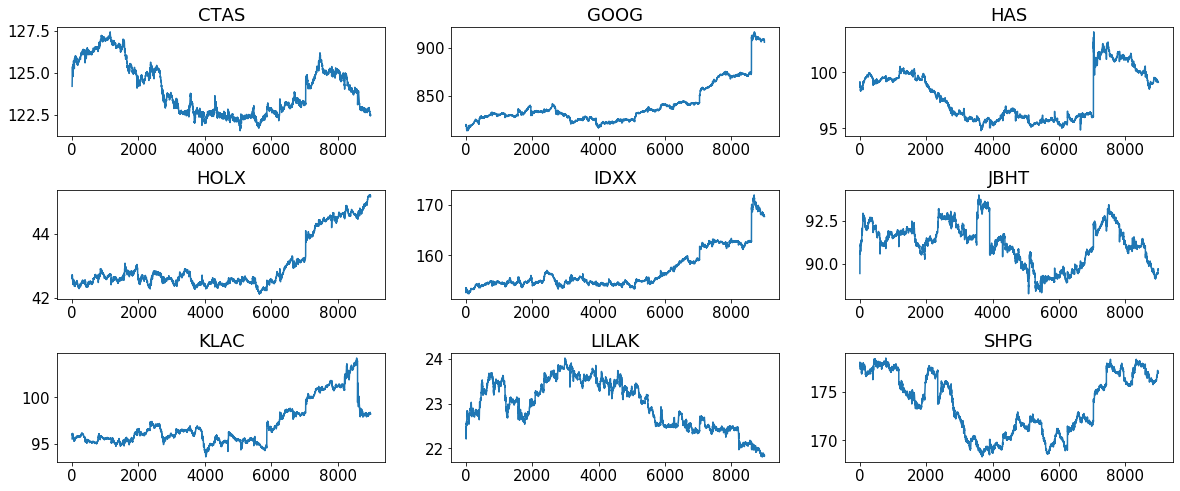

In [8]:
file=pd.read_csv(path+'/datasets/stock_preprocess.csv')
plt.figure(figsize=(20,8))
plt.rc('font',size=15)
for i, col in enumerate(file):
    plt.subplot(331+i)
    plt.plot(file[col])
    plt.title(col)
plt.subplots_adjust(hspace = 0.5)

In [9]:
file.shape

(8993, 9)

# generate inputs/ outputs

In [5]:
def make_neighbor_list(target, input_dim):
    neighbors=[target]
    for i in range(input_dim):
        if i == target:
            continue
        else:
            neighbors.append(i)

    return neighbors

    

def make_io(data, input_len,output_len,neighbors,split_size,shuffle=True):
    #neighbors should be a list where neighbors[0] is the target
    
    dataset1=[] #training dataset
    dataset2=[] #testing dataset
    
    package1=[[],[],[]]
    package2=[[],[],[]]
    data_len=data1.shape[0]
    data_dim=data1.shape[1]

    
    
    for j in range(data_len-input_len-output_len):
        one_x=[]
        one_y=[]
        i=neighbors[0]
        s=[scale[0][i],scale[1][i]]
        for k in neighbors:
                one_x.append(data[j:j+input_len,k].reshape(input_len,-1))
                one_y.append(data[j+input_len:j+input_len+output_len,k].reshape(output_len,-1))
                
        one_x=np.concatenate(one_x,axis=1)
        one_y=np.concatenate(one_y,axis=1)
        one_data=[one_x.tolist(),one_y.tolist(),s]
            
        if j<(data_len-split_size):
            dataset1.append(one_data)
        else:
            dataset2.append(one_data)
    if shuffle:
        random.shuffle(dataset1)
        random.shuffle(dataset2)
   
    for i in range(len(dataset1)):
        package1[0].append(dataset1[i][0])
        package1[1].append(dataset1[i][1])
        package1[2].append(dataset1[i][2])
    
    for i in range(len(dataset2)):
        package2[0].append(dataset2[i][0])
        package2[1].append(dataset2[i][1])
        package2[2].append(dataset2[i][2])
    #return dataset1,dataset2

    return package1, package2



In [12]:
inputs=make_neighbor_list(0, 9)
dataset3,dataset4=make_io(data1, 20, 10, inputs,2993,False)
X_train_valid=torch.FloatTensor(dataset3[0])
Y_train_valid=torch.FloatTensor(dataset3[1])[:,:,0].unsqueeze(2)
S_train_valid=torch.FloatTensor(dataset3[2])

X_test_valid=torch.FloatTensor(dataset4[0])
Y_test_valid=torch.FloatTensor(dataset4[1])[:,:,0].unsqueeze(2)
S_test_valid=torch.FloatTensor(dataset4[2])
X_train_valid.shape, X_test_valid.shape

(torch.Size([6000, 20, 9]), torch.Size([2963, 20, 9]))

# training function

In [5]:
def train(data, inputs, epochs, input_dim, input_len, output_len, split, model, loss_func, folder, constrain=False):
    
    testing_mae=0
    testing_mape=0
    
    target=inputs[0]
    print(file.columns[target])
    
    
    dataset1,dataset2=make_io(data, input_len,output_len,inputs,split)
    dataset3,dataset4=make_io(data, input_len,output_len,inputs,split,False)

    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
    S_train=torch.FloatTensor(dataset1[2])

    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
    S_test=torch.FloatTensor(dataset2[2])

    X_train_valid=torch.FloatTensor(dataset3[0])
    Y_train_valid=torch.FloatTensor(dataset3[1])[:,:,0].unsqueeze(2)
    S_train_valid=torch.FloatTensor(dataset3[2])

    X_test_valid=torch.FloatTensor(dataset4[0])
    Y_test_valid=torch.FloatTensor(dataset4[1])[:,:,0].unsqueeze(2)
    S_test_valid=torch.FloatTensor(dataset4[2])
        
    model.to(gpu) #model放到gpu裡
    print('number of parmeters:', util.count_parameters(model))
    
    for j in range(epochs):
        if j<500:
            rate=0.0001
        elif j>500 and j<2000:
            rate=0.00001
        else:
            rate=0.00001
        
        #rate=0.00001
        opt=torch.optim.Adam(model.parameters(),lr=rate)
        
        if constrain:
            model.weight.data.clamp_(0,1)
  
        #compute_loss(model, feature, label, batch, opt, train, loss_func, device)
        training_loss=util.compute_loss(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        testing_loss=util.compute_loss(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        test_mape=util.mape(model(X_test.to(gpu))[:,:,0].to(cpu),Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        if j%100==0:
            print('epoch:'+str(j))
            print('training mae loss:'+str(training_loss))
            print('testing mae loss:'+str(testing_loss))
            print('testing mape:'+str(test_mape))
            if constrain:
                print(model.weight.data)
    
    #except:
        
    model.to(cpu)   
     # plot_result(model, xs, ys, output_len, title, target_series, scale, save_path)
    util.plot_result(model, [X_train_valid,X_test_valid],[Y_train_valid,Y_test_valid],output_len,file.columns[target], target, 
                     scale, path+ '/results/plots/stock/'+method+'/')
    
    #plt.savefig(path+ '/results/plots/exchange_rate/'+data.columns[target]+'_prediction.png')
    #plt.clf()
    #    testing_mae+=testing_loss
    #    testing_mape+=mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
   
    return X_train_valid, Y_train_valid, X_test_valid, Y_test_valid
    

# Set gpu and loss functions

In [6]:
objective=torch.nn.L1Loss()
gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(gpu)
cpu=torch.device('cpu')

cuda:0


# train models 

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (7): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (8): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
    (W): Linear(in_features=32, out_features=32, bias=False)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 64, batch_first=True)
    (fc1): Linear(in_features=64, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
GOOG
number of parmeters: 15125
epoch:0
training mae loss:0.6866360008716583
testing mae loss:1.94536292552948
t

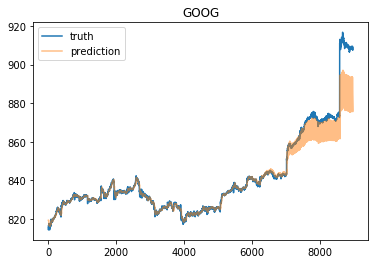

mae:  0.23079485
mape:  0.0072805076
smape:  0.0073540956


<Figure size 432x288 with 0 Axes>

In [23]:
import src.model

method="general"

seed=2

torch.manual_seed(seed)

targets=[1]
input_dim=9
cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)
fc_size=16
input_length=20
output_length=10

split=2993
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.model.S2S_cnn_attn(cnn_parameters,fc_size,input_dim,input_length,output_length, method=method)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(data1, inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    #torch.save(model, path+ '/results/models/'+method+'/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)

In [ ]:
torch.save(model, path+ '/results/models/'+method+'/'+data.columns[i]+'.pt')

basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(9, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
SHPG
number of parmeters: 10529
epoch:0
training mae loss:0.35588130354881287
testing mae loss:0.5136100649833679
testing mape:0.029784976
epoch:100
training mae loss:0.29400140047073364
testing mae loss:0.3909728229045868
testing mape:0.022652177
epoch:200
training mae loss:0.23949583619832993
testing mae loss:0.24541644752025604
testing mape:0.014264997
epoch:300
training mae loss:0.06819269806146622
testing mae loss:0.1700093150138855
testing mape:0.009903972
epoch:400
training mae loss:0.0429750457406044
testing mae loss:0.12592355906963348
testing mape:0.0073407944
epoch:500
training mae loss:0.027736530639231205
testing mae loss:0.09423176944255829
testing mape:0.005482592
epoch:600
training mae loss:0.023405746556818485
testing mae loss:0.09018808

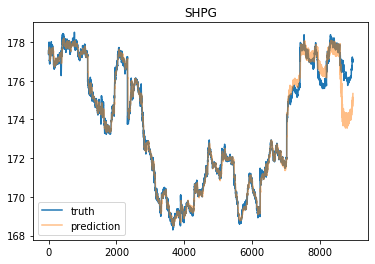

mae:  0.047053084
mape:  0.0027348432
smape:  0.0027422204


<Figure size 432x288 with 0 Axes>

In [66]:
import src.lstm_lstm

method=""

seed=3

torch.manual_seed(seed)

targets=[8]
input_dim=9

hidden_size=32
fc_size=16
input_length=20
output_length=10

split=2993
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    #basic_S2S(hidden_size,fc_size,input_length,input_dim,output_length)
    model=src.lstm_lstm.basic_S2S(hidden_size, fc_size, input_length, input_dim, output_length)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(data1, inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    #torch.save(model, path+ '/results/models/lstm/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

In [130]:
torch.save(model, path+ '/results/models/lstm/'+data.columns[i]+'.pt')

S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 9), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
SHPG
number of parmeters: 7701
epoch:0
training mae loss:0.5418722629547119
testing mae loss:0.6970717906951904
testing mape:0.040517595
epoch:100
training mae loss:0.31112223863601685
testing mae loss:0.4047568738460541
testing mape:0.023462083
epoch:200
training mae loss:0.2090594321489334
testing mae loss:0.1674766093492508
testing mape:0.009788451
epoch:300
training mae loss:0.05056216940283775
testing mae loss:0.0779636949300766
testing mape:0.0045363344
epoch:400
training mae loss:0.02698475681245327
testing mae loss:0.06810295581817627
testing mape:0.003959028
epoch:500
training mae loss:0.023270349018275738
testing mae loss:0.060935117304325104
testing mape

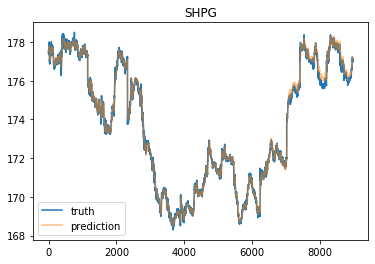

mae:  0.01863331
mape:  0.0010875694
smape:  0.0010874822


<Figure size 432x288 with 0 Axes>

In [73]:
import src.two_dim_cnn_gru

method=""

seed=1
torch.manual_seed(seed)

targets=[8]
input_dim=9

hidden_size=32
fc_size=16
input_length=20
output_length=10

cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)

split=2993
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    #S2S_2dcnn(cnn_parameters,rnn_hidden_size,fc_size,input_dim,output_length)
    model=src.two_dim_cnn_gru.S2S_2dcnn(cnn_parameters,hidden_size,fc_size,input_dim,output_length)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(data1, inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    torch.save(model, path+ '/results/models/2dcnn/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

In [70]:
torch.save(model, path+ '/results/models/2dcnn/'+data.columns[i]+'.pt')

# show results

In [35]:
i=0
method='bahdanau'
file_name=data.columns[i]
model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')

In [36]:
print(file_name)
inputs=make_neighbor_list(target=i, input_dim=9)

dataset1, dataset2=make_io(data1, input_len=20,output_len=10,neighbors=inputs, split_size=2993, shuffle=False)
X_train=torch.FloatTensor(dataset1[0])
X_test=torch.FloatTensor(dataset2[0])
Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
print(test_mae)
test_mape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
print(test_mape)

CTAS
0.017638687
0.00083846407


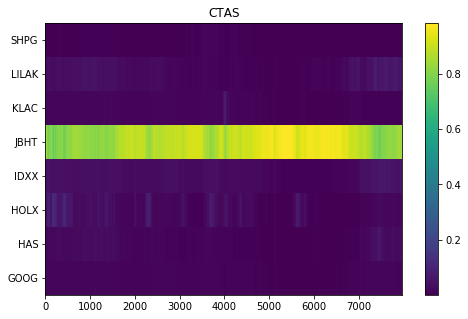

[[0.011316811665892601,
  0.013412837870419025,
  0.017664119601249695,
  0.03672846779227257,
  0.8506636619567871,
  0.011316811665892601,
  0.05611136555671692,
  0.0027859844267368317],
 [0.011106952093541622,
  0.012885653413832188,
  0.017937185242772102,
  0.03369252011179924,
  0.8592382073402405,
  0.011106952093541622,
  0.05126722529530525,
  0.0027653230354189873],
 [0.011072326451539993,
  0.013046283274888992,
  0.018798310309648514,
  0.034057144075632095,
  0.8622648119926453,
  0.011072326451539993,
  0.04691433534026146,
  0.0027744390536099672],
 [0.010950800962746143,
  0.013411913067102432,
  0.020131295546889305,
  0.03336358815431595,
  0.865583598613739,
  0.010950800962746143,
  0.04286251217126846,
  0.002745568985119462],
 [0.01081305555999279,
  0.013392562977969646,
  0.021760087460279465,
  0.034175675362348557,
  0.8675729632377625,
  0.01081305555999279,
  0.038770679384469986,
  0.00270195328630507],
 [0.010788273066282272,
  0.01290565449744463,
  0.02

<Figure size 432x288 with 0 Axes>

In [37]:
attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/stock/'+method+'/')
attns

In [60]:
file=pd.read_csv(path+'/datasets/stock_preprocess.csv')
data=(file-file[:-2993].min())/(file[:-2993].max()-file[:-2993].min())
data1=data.values
data1.shape

(8993, 9)

In [57]:
[file[:-2993].max().tolist(),file[:-2993].min().tolist()]

[[127.45,
  842.2999999999997,
  100.54,
  43.08,
  157.03,
  94.02,
  97.44,
  24.02,
  178.51],
 [121.55, 814.22, 94.78, 42.13, 152.39, 88.23, 93.65, 22.21, 168.29]]

In [58]:
scale

[[127.45,
  842.2999999999997,
  100.54,
  43.08,
  157.03,
  94.02,
  97.44,
  24.02,
  178.51],
 [121.55, 814.22, 94.78, 42.13, 152.39, 88.23, 93.65, 22.21, 168.29]]

0.029455895
0.14043283881619573


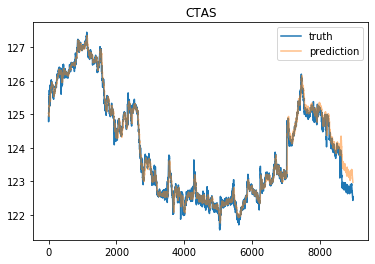

0.14690688
0.46331225894391537


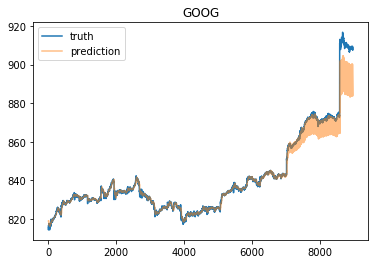

0.034480274
0.19846439827233553


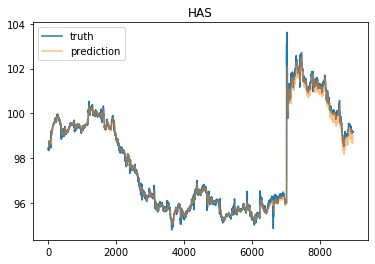

0.26531702
0.5664159543812275


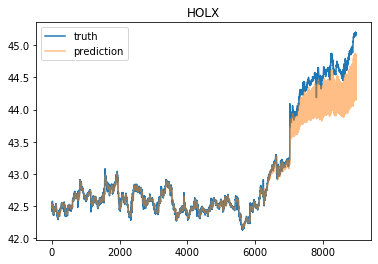

0.25453743
0.7117684464901686


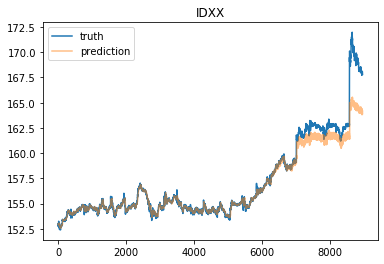

0.0376532
0.24078956339508295


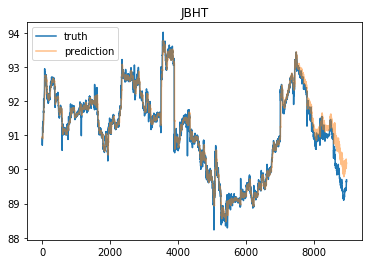

0.11302865
0.42289653792977333


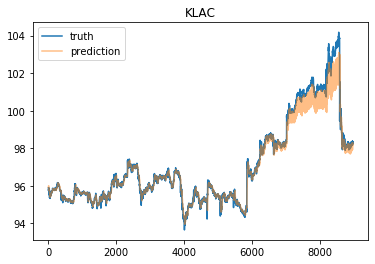

0.02675322
0.217227335087955


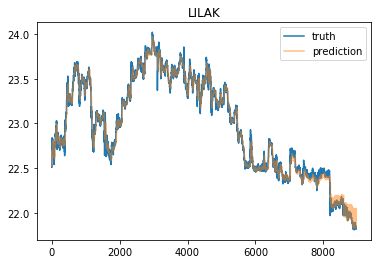

0.017311893
0.10105320252478123


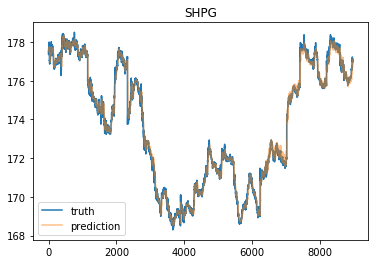

<Figure size 432x288 with 0 Axes>

In [65]:
method="general"
for i in range(9):
    file_name=data.columns[i]
    model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
    inputs=make_neighbor_list(target=i, input_dim=9)

    dataset1, dataset2=make_io(input_len=20,output_len=10,neighbors=inputs, split_size=2993, shuffle=False)
    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])
    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print(test_mae)
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print(100*test_mape)
    target=inputs[0]
    util.plot_result(model, [X_train,X_test],[Y_train,Y_test],10,data.columns[target], target, 
                     scale, path+ '/results/plots/stock/'+method+'/')

CTAS
0.018054195
0.08587483898736537


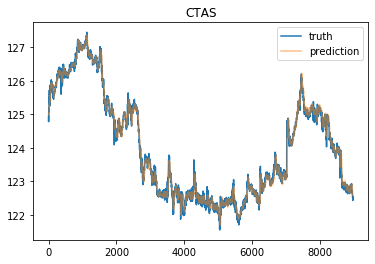

<Figure size 432x288 with 0 Axes>

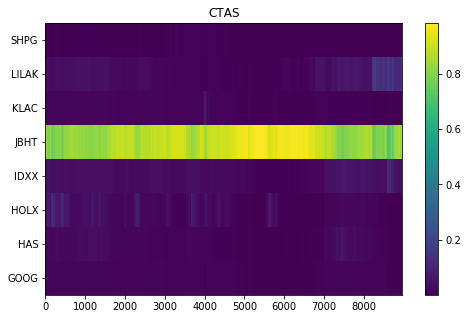

GOOG
0.18897887
0.5946025252342224


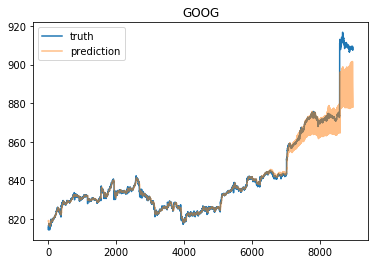

<Figure size 432x288 with 0 Axes>

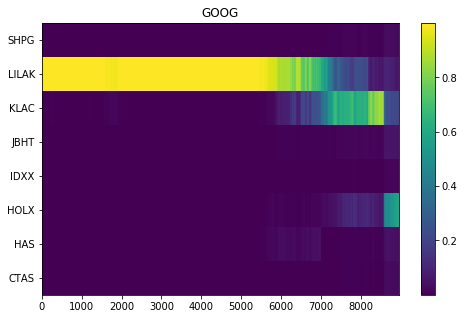

HAS
0.03145591
0.18040065187960863


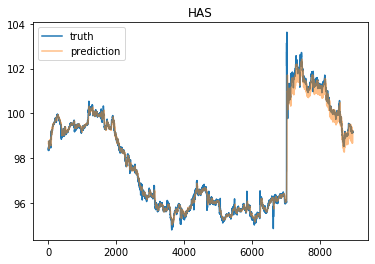

<Figure size 432x288 with 0 Axes>

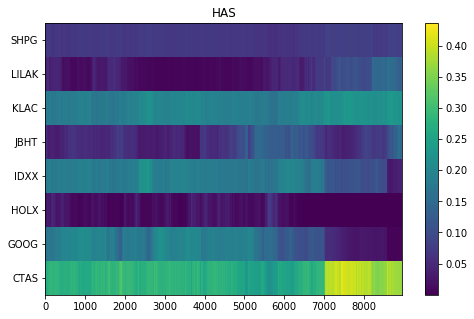

HOLX
0.1161309
0.24922466836869717


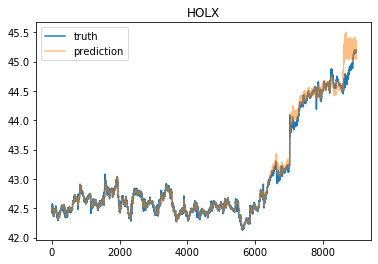

<Figure size 432x288 with 0 Axes>

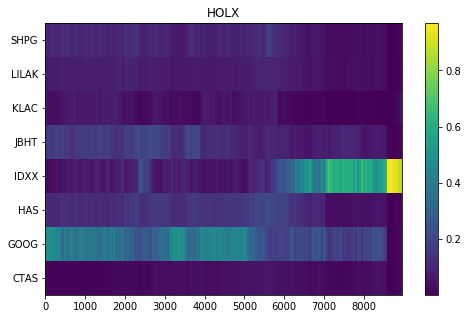

IDXX
0.1422335
0.3977919463068247


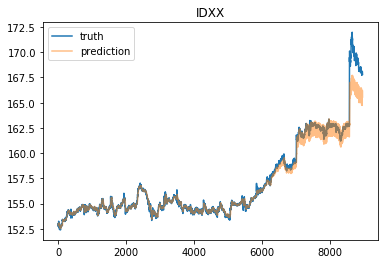

<Figure size 432x288 with 0 Axes>

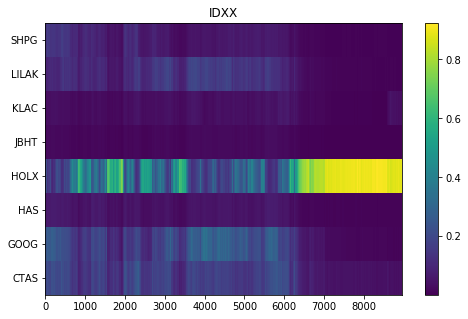

JBHT
0.019209111
0.1222696271724999


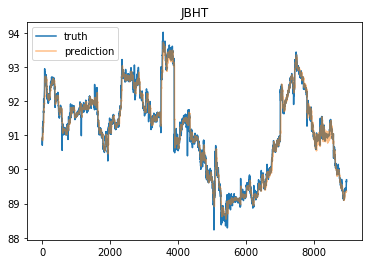

<Figure size 432x288 with 0 Axes>

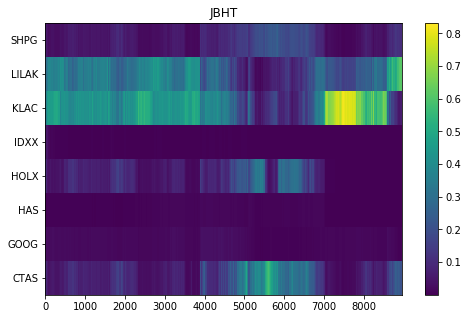

KLAC
0.1280305
0.4852958954870701


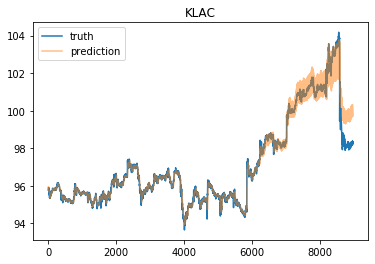

<Figure size 432x288 with 0 Axes>

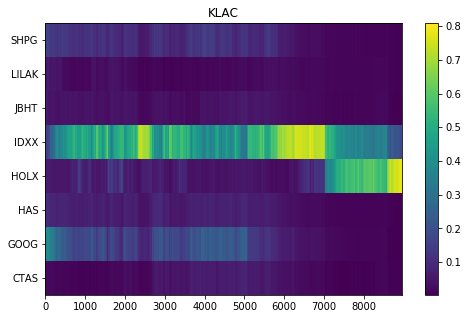

LILAK
0.024441646
0.1988067990168929


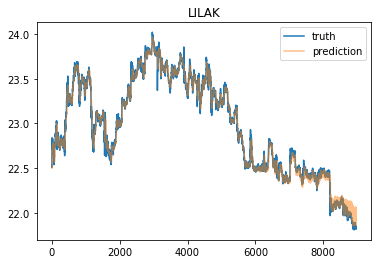

<Figure size 432x288 with 0 Axes>

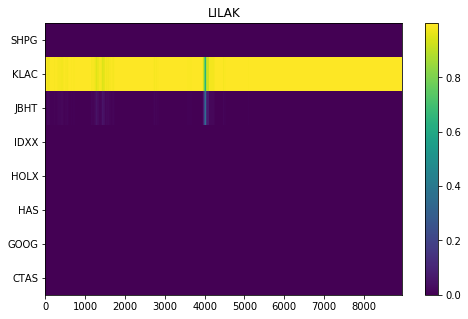

SHPG
0.017697517
0.10322618763893843


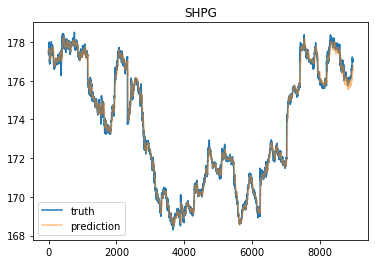

<Figure size 432x288 with 0 Axes>

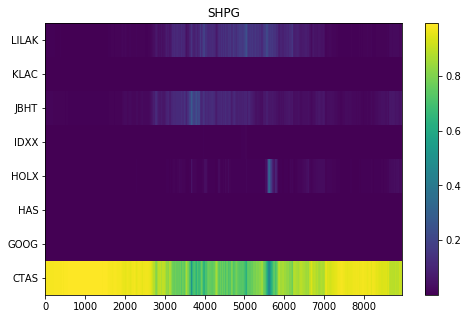

<Figure size 432x288 with 0 Axes>

In [67]:
method="bahdanau"
for i in range(9):
    file_name=data.columns[i]
    print(file_name)
    model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
    inputs=make_neighbor_list(target=i, input_dim=9)

    dataset1, dataset2=make_io(input_len=20,output_len=10,neighbors=inputs, split_size=2993, shuffle=False)
    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])
    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print(test_mae)
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print(100*test_mape)
    target=inputs[0]
    util.plot_result(model, [X_train,X_test],[Y_train,Y_test],10,data.columns[target], target, 
                     scale, path+ '/results/plots/stock/'+method+'/')
    attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/stock/'+method+'/')

# noise test

In [5]:
data.shape

(8993, 9)

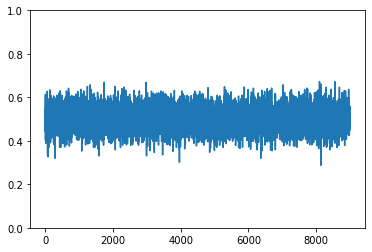

In [6]:
#noise=pd.read_csv('noise.csv')
mu=0.5
sigma=0.05
noise=np.random.normal(mu, sigma, len(file))#+0.25*np.sin([0.01*i for i in range(len(file))])
noise=np.expand_dims(noise, axis=1)
plt.ylim(0,1)
plt.plot(noise)

/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.S2S_cnn_attn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


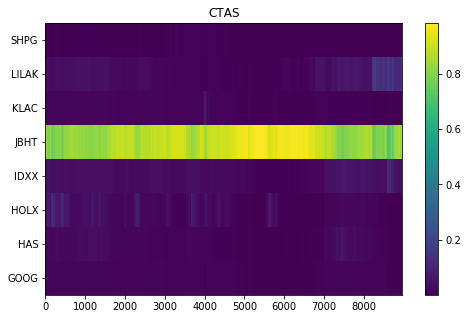

original mae: 0.018054195
original test smape: 0.0008588333
original train smape: 0.00078079075
1 0.008828629810382542
2 0.01469667658758756
3 0.008971081736828871
4 0.036448099745680786
5 0.8626302687292199
6 0.005082422015852811
7 0.060745929092183897
8 0.0025968921568018857
0 0
1 0.0008588333
2 0.0008405765
3 0.00083351217
4 0.00082642556
5 0.00091316993
6 0.0008629909
7 0.0008548603
8 0.00086038176


<Figure size 432x288 with 0 Axes>

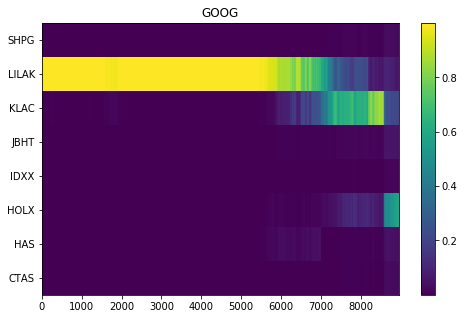

original mae: 0.18897887
original test smape: 0.006004571
original train smape: 0.00064166234
0 0.0051002238766792215
2 0.017437042483937817
3 0.10811477436514655
4 0.002826818384004732
5 0.01403065424470952
6 0.42796687556256563
7 0.4169600000853298
8 0.0075636101880383
0 0.006003998
1 1
2 0.0060438565
3 0.0069834776
4 0.00603224
5 0.005999819
6 0.0060495427
7 0.0065671545
8 0.006006085


<Figure size 432x288 with 0 Axes>

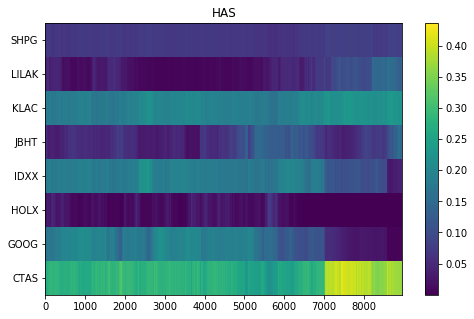

original mae: 0.03145591
original test smape: 0.0018118595
original train smape: 0.00089204026
0 0.34573245217500004
1 0.05753841792656674
3 0.001509968768104362
4 0.125727896346958
5 0.08384259573177354
6 0.2142591044291668
7 0.09541994659843032
8 0.07596961849023674
0 0.0018870553
1 0.0022231615
2 2
3 0.0017816828
4 0.0019926438
5 0.001841068
6 0.001739108
7 0.0017962598
8 0.0018322455


<Figure size 432x288 with 0 Axes>

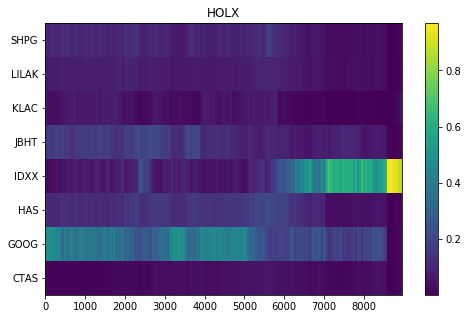

original mae: 0.1161309
original test smape: 0.0024857284
original train smape: 0.0006629911
0 0.029291472572347994
1 0.17756305264693772
2 0.06795270950902772
4 0.5620705880528964
5 0.06808811916780812
6 0.01106716841361443
7 0.04123315349214315
8 0.042733735798984145
0 0.0024935205
1 0.0030553069
2 0.0024761194
3 3
4 0.0036846134
5 0.0025475998
6 0.0024472289
7 0.0024864941
8 0.0024859942


<Figure size 432x288 with 0 Axes>

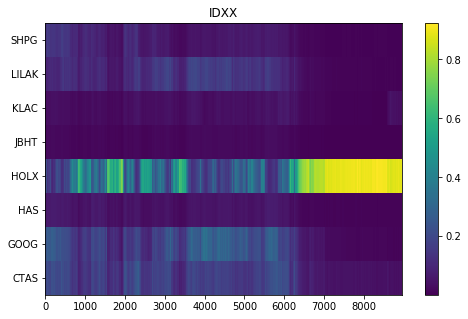

original mae: 0.1422335
original test smape: 0.004001476
original train smape: 0.00077182037
0 0.06531904887004435
1 0.04485284466952729
2 0.015615955282598633
3 0.8142298036558259
5 0.005438658114933823
6 0.018600043267705656
7 0.02231276138923582
8 0.013630885479502176
0 0.003865595
1 0.0039949976
2 0.0040220204
3 0.0029831885
4 4
5 0.0040017315
6 0.004106687
7 0.0040027346
8 0.0040130974


<Figure size 432x288 with 0 Axes>

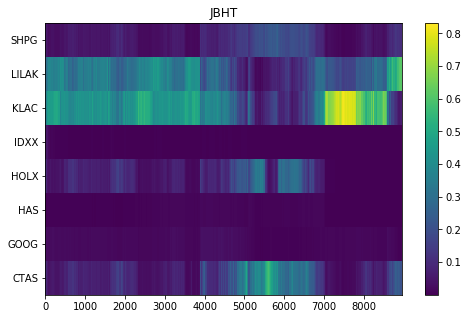

original mae: 0.019209111
original test smape: 0.0012234675
original train smape: 0.0012991611
0 0.14096797387569218
1 0.01229374187415729
2 0.004984984065184745
3 0.06921364361740445
4 0.00031769162637468475
6 0.44172544017750953
7 0.24543045472744707
8 0.08506607070220731
0 0.0012233164
1 0.0011997926
2 0.0012219946
3 0.0012108828
4 0.0012222602
5 5
6 0.001099468
7 0.001277699
8 0.0012224375


<Figure size 432x288 with 0 Axes>

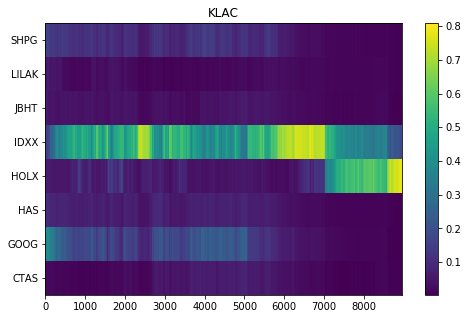

original mae: 0.1280305
original test smape: 0.0048400303
original train smape: 0.00095232384
0 0.01421593437948834
1 0.02564176280724738
2 0.017305144334040328
3 0.39849890457227993
4 0.49021881248976706
5 0.016773312929213056
7 0.016391379592284545
8 0.020954749486910465
0 0.0048438245
1 0.004792685
2 0.0048362347
3 0.004631394
4 0.005322958
5 0.004829768
6 6
7 0.0048549026
8 0.004839112


<Figure size 432x288 with 0 Axes>

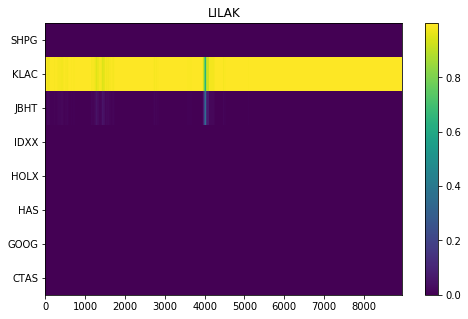

original mae: 0.024441646
original test smape: 0.0019860906
original train smape: 0.0017094697
0 1.7113683857870363e-11
1 1.2357156896815067e-08
2 1.5548322189366406e-09
3 8.461498825671286e-10
4 1.4105895893201707e-12
5 6.654454156262416e-05
6 0.9999334367794883
8 3.0568418864501857e-10
0 0.0019860906
1 0.0019860906
2 0.0019860903
3 0.0019860906
4 0.0019860906
5 0.0019872775
6 0.002489376
7 7
8 0.0019860906


<Figure size 432x288 with 0 Axes>

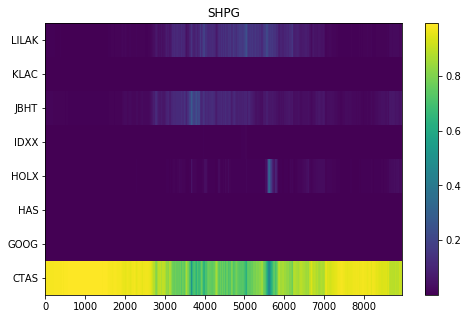

original mae: 0.017697517
original test smape: 0.0010330875
original train smape: 0.0010355347
0 0.9191104015747197
1 3.1955107210781633e-06
2 0.00016992435613436314
3 0.012602821262704206
4 1.7713127259563738e-05
5 0.03434926280805258
6 0.00019721794502835604
7 0.03354945586618052
0 0.0009582938
1 0.0010331245
2 0.0010331696
3 0.0012055493
4 0.0010340952
5 0.0010913406
6 0.00103362
7 0.0010115666
8 8


<Figure size 432x288 with 0 Axes>

In [17]:
method='bahdanau'
feature_importance=[]
ranks=[]
truths=[]
original_smape=0

for i in range(9):
    file_name=data.columns[i]
    model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
    data1=data.values
    inputs=make_neighbor_list(target=i, input_dim=9)
    dataset1, dataset2=make_io(data1, input_len=20,output_len=10,neighbors=inputs, split_size=2993, shuffle=False)
    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)

    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    train_smape=util.smape(model(X_train)[:,:,0],Y_train[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
    attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/'+method+'/')
    print("original mae:",test_mae)
    print("original test smape:",test_smape)
    print("original train smape:", train_smape)
    original_smape+=test_smape
    #original_smape+=train_smape
    
    attns=np.array(attns)
    importance=[]
    for k in range(1,9):
        print(inputs[k], attns[6000:,k-1].mean())
        importance.append([inputs[k], attns[6000:,k-1].mean()])
        #importance.append([inputs[k], attns[:6000,k-1].mean()])
        
    sorted_importance=sorted(importance, key= lambda importance: importance[1])
    rank=[sorted_importance[i][0] for i in range(8)]
    ranks.append(rank)
    smape=[]
    truth=[]
    #for k in rank:
    for k in range(9):
        if k==i:
            print(i,k)
            smape.append(0)
            continue
            
        data2=data1.copy()
        data2[:,k]=noise.reshape(-1)
        dataset1, dataset2=make_io(data2, input_len=20,output_len=10,neighbors=inputs, split_size=2993, shuffle=False)
        X_train=torch.FloatTensor(dataset1[0])
        Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        #train_smape=util.smape(model(X_train)[:,:,0],Y_train[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        #print(str(k),train_smape)
        #smape.append(train_smape)
        #truth.append([k,train_smape])
        print(str(k),test_smape)
        smape.append(test_smape)
        truth.append([k,test_smape])
    
    truth=sorted(truth, key= lambda truth: truth[1])
    feature_importance.append(smape)
    truths.append([sublist[0] for sublist in truth])

In [18]:
FI=pd.DataFrame(feature_importance)#.transpose()
#ranking=pd.DataFrame(ranks)
FI

,0,1,2,3,4,5,6,7,8
0,0.000000,0.000859,0.000841,0.000834,0.000826,0.000913,0.000863,0.000855,0.000860
1,0.006004,0.000000,0.006044,0.006983,0.006032,0.006000,0.006050,0.006567,0.006006
2,0.001887,0.002223,0.000000,0.001782,0.001993,0.001841,0.001739,0.001796,0.001832
3,0.002494,0.003055,0.002476,0.000000,0.003685,0.002548,0.002447,0.002486,0.002486
4,0.003866,0.003995,0.004022,0.002983,0.000000,0.004002,0.004107,0.004003,0.004013
5,0.001223,0.001200,0.001222,0.001211,0.001222,0.000000,0.001099,0.001278,0.001222
6,0.004844,0.004793,0.004836,0.004631,0.005323,0.004830,0.000000,0.004855,0.004839
7,0.001986,0.001986,0.001986,0.001986,0.001986,0.001987,0.002489,0.000000,0.001986
8,0.000958,0.001033,0.001033,0.001206,0.001034,0.001091,0.001034,0.001012,0.000000


In [19]:
ranks

[[8, 6, 1, 3, 2, 4, 7, 5],
 [4, 0, 8, 5, 2, 3, 7, 6],
 [3, 1, 8, 5, 7, 4, 6, 0],
 [6, 0, 7, 8, 2, 5, 1, 4],
 [5, 8, 2, 6, 7, 1, 0, 3],
 [4, 2, 1, 3, 8, 0, 7, 6],
 [0, 7, 5, 2, 8, 1, 3, 4],
 [4, 0, 8, 3, 2, 1, 5, 6],
 [1, 4, 2, 6, 3, 7, 5, 0]]

In [20]:
col_dict={file.columns[i]:i for i in range(9)}
corr=file[6000:].corr()
#corr=file[:6000].corr()
col_dict

{'CTAS': 0,
 'GOOG': 1,
 'HAS': 2,
 'HOLX': 3,
 'IDXX': 4,
 'JBHT': 5,
 'KLAC': 6,
 'LILAK': 7,
 'SHPG': 8}

In [21]:
correlation_ranking=[]
for i in range(9):
    rank=[col_dict[abs(corr[corr.columns[i]]).sort_values().index[j]] for j in range(8)]
    correlation_ranking.append(rank)
correlation_ranking    

[[1, 4, 7, 3, 8, 6, 2, 5],
 [5, 0, 6, 2, 8, 7, 3, 4],
 [7, 1, 4, 6, 5, 3, 0, 8],
 [5, 0, 7, 6, 2, 4, 1, 8],
 [0, 5, 6, 2, 8, 7, 3, 1],
 [1, 7, 4, 3, 8, 6, 2, 0],
 [7, 4, 1, 5, 3, 0, 2, 8],
 [5, 0, 2, 6, 8, 3, 4, 1],
 [7, 5, 0, 4, 1, 6, 2, 3]]

In [22]:
model_importance=[]
correlation_importance=[]
truth_importance=[]
for i in range(9):
    model_importance.append([original_smape/9]+[FI.iloc[i][j] for j in ranks[i]])
    correlation_importance.append([original_smape/9]+[FI.iloc[i][j] for j in correlation_ranking[i]])
    #truth_importance.append([original_smape/9]+[FI.iloc[i][j] for j in truths[i]])
    

In [23]:
ranks[0]

[8, 6, 1, 3, 2, 4, 7, 5]

([<matplotlib.axis.XTick at 0x7f2e606cfd10>,
 <a list of 9 Text xticklabel objects>)

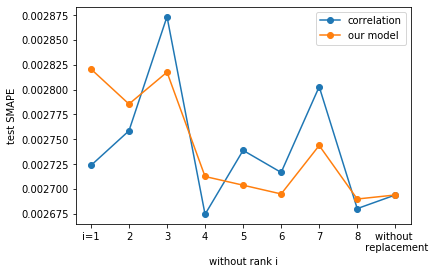

In [24]:
ticks=[str(i) for i in range(1,10)]
ticks[0]="i=1"
ticks[-1]="without \n replacement"

plt.plot(pd.DataFrame(correlation_importance).mean().tolist()[::-1],'-o')
plt.plot(pd.DataFrame(model_importance).mean().tolist()[::-1],'-o')

plt.xlabel("without rank i")
#plt.ylabel("train SMAPE")
plt.ylabel("test SMAPE")
plt.legend(["correlation","our model"])
plt.xticks([i for i in range(9)],ticks)

In [15]:
np.corrcoef(pd.DataFrame(correlation_importance).mean().tolist()[::-1],[i for i in range(9)])

array([[ 1.        , -0.66542295],
       [-0.66542295,  1.        ]])

In [16]:
np.corrcoef(pd.DataFrame(model_importance).mean().tolist()[::-1],[i for i in range(9)])

array([[ 1.        , -0.74801791],
       [-0.74801791,  1.        ]])

In [25]:
from scipy import stats
stats.kendalltau(pd.DataFrame(correlation_importance).mean().tolist()[::-1],[i for i in range(9)])

KendalltauResult(correlation=-0.2222222222222222, pvalue=0.47670855379188715)

In [26]:
stats.kendalltau(pd.DataFrame(model_importance).mean().tolist()[::-1],[i for i in range(9)])

KendalltauResult(correlation=-0.7222222222222222, pvalue=0.0058862433862433864)

# fitting result

In [7]:
target_series=5
file_name=data.columns[target_series]
inputs=make_neighbor_list(target=target_series, input_dim=9)

In [8]:
model_name=["lstm","2dcnn","none","dot","general","bahdanau"]

model1=torch.load(path+ '/results/models/lstm/'+file_name+'.pt')
model2=torch.load(path+ '/results/models/2dcnn/'+file_name+'.pt')
model3=torch.load(path+ '/results/models/none/'+file_name+'.pt')
model4=torch.load(path+ '/results/models/dot/'+file_name+'.pt')
model5=torch.load(path+ '/results/models/general/'+file_name+'.pt')
model6=torch.load(path+ '/results/models/bahdanau/'+file_name+'.pt')
models=[torch.load(path+ '/results/models/'+name+'/'+file_name+'.pt') for name in model_name]

In [9]:
dataset1, dataset2=make_io(data1, input_len=20,output_len=10,neighbors=inputs, split_size=2993, shuffle=False)
X_train=torch.FloatTensor(dataset1[0])
Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
X_test=torch.FloatTensor(dataset2[0])
Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
X=torch.cat([X_train, X_test])
Y=torch.cat([Y_train, Y_test])

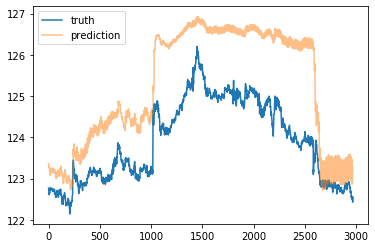

In [64]:
result=[]
truth=[]


for j in range(0,X_test.shape[0],10):
    prediction=model1(X_test[j].unsqueeze(0))[:,:,0].squeeze(0).tolist()
    y=Y_test[j,:,0].tolist()
        
    result.extend([k*(scale[0][target_series]-scale[1][target_series])+scale[1][target_series] for k in prediction])
    truth.extend([k*(scale[0][target_series]-scale[1][target_series])+scale[1][target_series] for k in y])
        
plt.plot(truth)
plt.plot(result,alpha=0.5)
plt.legend(['truth','prediction'])
#plt.title(title)
    #plt.savefig(save_path+title+'_prediction.png')
plt.show()

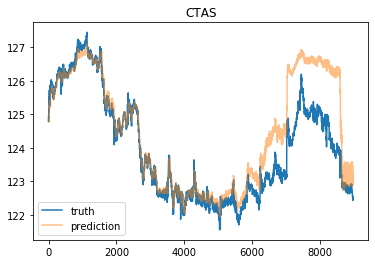

([124.8035434782505,
  124.8509507060051,
  124.84405415654183,
  124.81813662052154,
  124.8001569211483,
  124.78990757465363,
  124.78560035228729,
  124.78557468056678,
  124.78852024674416,
  124.79346926212311,
  124.7899135529995,
  124.83445363640786,
  124.83023151755333,
  124.80588945150376,
  124.7886243402958,
  124.77862221598625,
  124.77431780695915,
  124.77415639162064,
  124.77688462734223,
  124.78157235383988,
  125.16381864547729,
  125.20819203853607,
  125.19305099844932,
  125.17417454719543,
  125.16254314780235,
  125.15788390636445,
  125.15870751142502,
  125.163658285141,
  125.17162882685662,
  125.18176071643829,
  125.36463585495949,
  125.41244398355484,
  125.4182018339634,
  125.4018106162548,
  125.39268344044686,
  125.39047813415527,
  125.39301013946533,
  125.39626517295838,
  125.40265637636185,
  125.41146494150162,
  125.23834822177886,
  125.30329099297523,
  125.29462485313415,
  125.27543225288392,
  125.26404772400856,
  125.2599915921688

<Figure size 432x288 with 0 Axes>

In [65]:
util.plot_result(model1, [X_train,X_test],[Y_train,Y_test],10,data.columns[target_series],target_series, 
                     scale, path+ '')

Text(0.5, 0.98, 'CTAS')

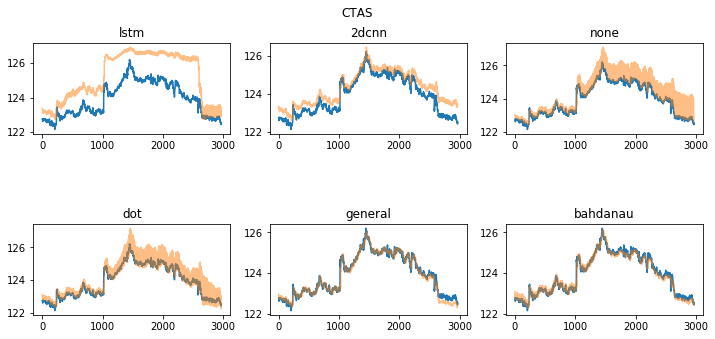

In [66]:
result=[[] for i in range(6)]

plt.figure(figsize=[12,5])
plt.subplots_adjust(hspace=1)
for i in range(6):
    plt.subplot(231+i)
    for j in range(0,X_test.shape[0],10):
        prediction=models[i](X_test[j].unsqueeze(0))[:,:,0].squeeze(0).tolist()
        
        result[i].extend([k*(scale[0][target_series]-scale[1][target_series])+scale[1][target_series] for k in prediction])
    plt.plot(truth)
    plt.plot(result[i],alpha=0.5)
    plt.title(model_name[i])
plt.suptitle(file_name)    
#plt.plot(result,alpha=0.5)
#plt.legend(['truth','prediction'])

    #plt.savefig(save_path+title+'_prediction.png')
#plt.show()

Text(0.5, 0.98, 'JBHT')

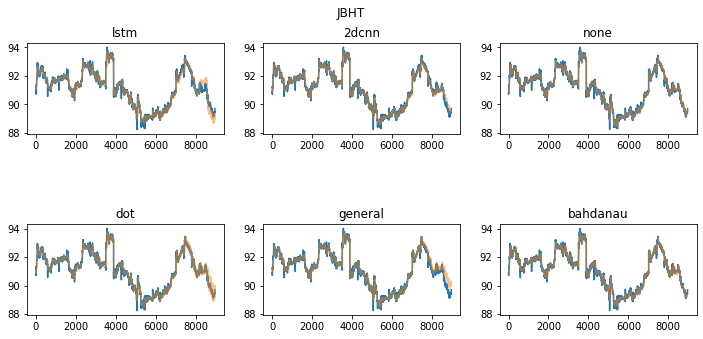

In [10]:
result=[[] for i in range(6)]
truth=[[] for i in range(6)]

plt.figure(figsize=[12,5])
plt.subplots_adjust(hspace=1)
for i in range(6):
    plt.subplot(231+i)
    for j in range(0,X.shape[0],10):
        prediction=models[i](X[j].unsqueeze(0))[:,:,0].squeeze(0).tolist()
        y=Y[j,:,0].tolist()
        result[i].extend([k*(scale[0][target_series]-scale[1][target_series])+scale[1][target_series] for k in prediction])
        truth[i].extend([k*(scale[0][target_series]-scale[1][target_series])+scale[1][target_series] for k in y])
    plt.plot(truth[i])
    plt.plot(result[i],alpha=0.5)
    plt.title(model_name[i])
plt.suptitle(file_name)    
#plt.plot(result,alpha=0.5)
#plt.legend(['truth','prediction'])

    #plt.savefig(save_path+title+'_prediction.png')
#plt.show()

# first/last performance

In [5]:

def first_last(method, step):
    #mae=0
    #smape=0
    mae=[]
    smape=[]
    for i in range(9):
        file_name=data.columns[i]
        model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
        inputs=make_neighbor_list(target=i, input_dim=9)
        dataset1, dataset2=make_io(data1,input_len=20,output_len=10,neighbors=inputs, split_size=2993, shuffle=False)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        mae.append(util.mae(model(X_test)[:,step,:],Y_test[:,step,:]))
        smape.append(util.smape(model(X_test)[:,step,:],Y_test[:,step,:],(scale[0][i]-scale[1][i]),scale[1][i]))
    return mae, smape
        #mae+=abs(model(X_test)[:,step,:]-Y_test[:,step,:]).mean()
        #smape+=util.smape(model(X_test)[:,step,:],Y_test[:,step,:],(scale[0][i]-scale[1][i]),scale[1][i])
    #return mae.item()/9, smape/9

In [6]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
for name in model_names:
    first=first_last(name, 0)
    #last=first_last(name, -1)
    print(name, "mae:",np.mean(first[0]),"/",np.std(first[0]))
    print(name, "smape:",np.mean(first[1]),"/",np.std(first[1]))

/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.S2S_cnn_attn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


bahdanau mae: 0.07929103 / 0.072641
bahdanau smape: 0.002822386 / 0.0020146328
dot mae: 0.13582514 / 0.10759952
dot smape: 0.0049780225 / 0.003179957
general mae: 0.08711788 / 0.06703372
general smape: 0.0030780775 / 0.001482695
none mae: 0.08825423 / 0.07159682
none smape: 0.0031108323 / 0.0020510403
lstm mae: 0.25609517 / 0.23793639
lstm smape: 0.008361642 / 0.005865669
2dcnn mae: 0.2278897 / 0.21638606
2dcnn smape: 0.0075168377 / 0.0054227845


In [7]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
for name in model_names:
    #first=first_last(name, 0)
    last=first_last(name, -1)
    print(name, "mae:",np.mean(last[0]),"/",np.std(last[0]))
    print(name, "smape:",np.mean(last[1]),"/",np.std(last[1]))

bahdanau mae: 0.09373036 / 0.08858697
bahdanau smape: 0.0033648997 / 0.002610922
dot mae: 0.16738503 / 0.1616097
dot smape: 0.0054577347 / 0.0039422074
general mae: 0.15372077 / 0.14975716
general smape: 0.0049363663 / 0.0033096543
none mae: 0.15074182 / 0.14419256
none smape: 0.0049130693 / 0.0034905144
lstm mae: 0.31605828 / 0.2888535
lstm smape: 0.010389304 / 0.007301686
2dcnn mae: 0.20732549 / 0.20177637
2dcnn smape: 0.00668788 / 0.005084928


In [10]:
first_last('bahdanau', 1)

(0.0655080344941881, 0.002277714459018575)

In [5]:

def all_performance(method):
    #mae=0
    #smape=0
    mae=[]
    smape=[]
    for i in range(9):
        file_name=data.columns[i]
        model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
        inputs=make_neighbor_list(target=i, input_dim=9)
        dataset1, dataset2=make_io(data1,input_len=20,output_len=10,neighbors=inputs, split_size=2993, shuffle=False)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        mae.append(util.mae(model(X_test)[:,:,0],Y_test[:,:,0]))
        smape.append(util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i]))
    return mae, smape
        #mae+=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
        #smape+=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    #return mae.item()/9, smape/9

In [6]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
all_mae=[]
all_smape=[]
for name in model_names:
    mae, smape=all_performance(name)
    all_mae.append(mae)
    all_smape.append(smape)
    #print(name, "mae:",first[0])
    #print(name, "smape:",first[1])

/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.S2S_cnn_attn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [7]:
all_mae=pd.DataFrame(all_mae, index=model_names).transpose()
all_smape=pd.DataFrame(all_smape,index=model_names).transpose()

In [8]:
all_mae

,bahdanau,dot,general,none,lstm,2dcnn
0,0.018054,0.033071,0.029456,0.028800,0.075006,0.022555
1,0.188979,0.204165,0.146907,0.206090,0.608045,0.342473
2,0.031456,0.037362,0.034480,0.037016,0.099463,0.057646
3,0.116131,0.236915,0.265317,0.234421,0.641795,0.457288
4,0.142234,0.330588,0.254537,0.287236,0.536571,0.442948
5,0.019209,0.032108,0.037653,0.020016,0.037379,0.024417
6,0.128030,0.180603,0.113029,0.155413,0.342591,0.281945
7,0.024442,0.039578,0.026753,0.030926,0.054830,0.054529
8,0.017698,0.021344,0.017312,0.025388,0.041757,0.018633


In [9]:
all_mae.mean(), all_mae.std()

(bahdanau    0.076248
 dot         0.123971
 general     0.102827
 none        0.113923
 lstm        0.270826
 2dcnn       0.189159
 dtype: float64, bahdanau    0.067168
 dot         0.115619
 general     0.099290
 none        0.106934
 lstm        0.261830
 2dcnn       0.189675
 dtype: float64)

In [10]:
all_smape.mean(), all_smape.std()

(bahdanau    0.002694
 dot         0.004222
 general     0.003419
 none        0.003814
 lstm        0.008919
 2dcnn       0.006167
 dtype: float64, bahdanau    0.001833
 dot         0.002852
 general     0.002123
 none        0.002601
 lstm        0.006518
 2dcnn       0.004767
 dtype: float64)